<a href="https://colab.research.google.com/github/Kogila2004/MY-LEARNING/blob/main/Image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub


path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dog-and-cat-classification-dataset' dataset.
Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


In [ ]:
from pathlib import Path
import random
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from scipy.ndimage import shift
import cv2
import os

In [ ]:
root = Path(r"/kaggle/input/dog-and-cat-classification-dataset/PetImages")  # dataset/cats, dataset/dogs
cat_dir = root / "Cat"
dog_dir = root / "Dog"

cat_files = list(cat_dir.glob("*.jpg"))
dog_files = list(dog_dir.glob("*.jpg"))

random.seed(42)
cat_pick = random.sample(cat_files, 200)
dog_pick = random.sample(dog_files, 200)

X, y = [], []
target_size = (128, 128)  # resize về 128x128, bạn có thể đổi

for f in cat_pick:
    img = Image.open(f).convert("RGB").resize(target_size)
    X.append(np.array(img))
    y.append(0)

for f in dog_pick:
    img = Image.open(f).convert("RGB").resize(target_size)
    X.append(np.array(img))
    y.append(1)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (400, 128, 128, 3)
y shape: (400,)


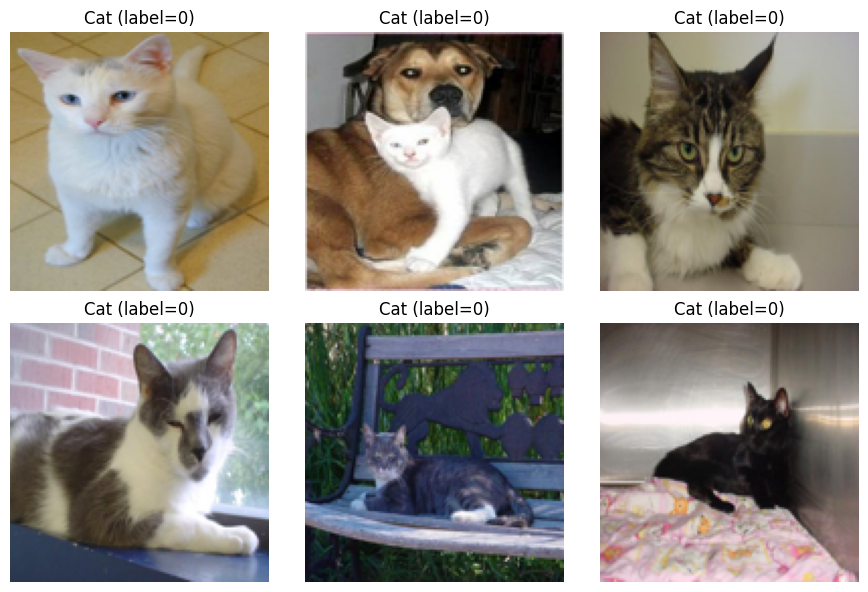

In [ ]:
#show ảnh
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(X[i])  # X[i] đã là RGB
    label = "Cat" if y[i] == 0 else "Dog"
    ax.set_title(f"{label} (label={y[i]})")
    ax.axis("off")

plt.tight_layout()
plt.show()

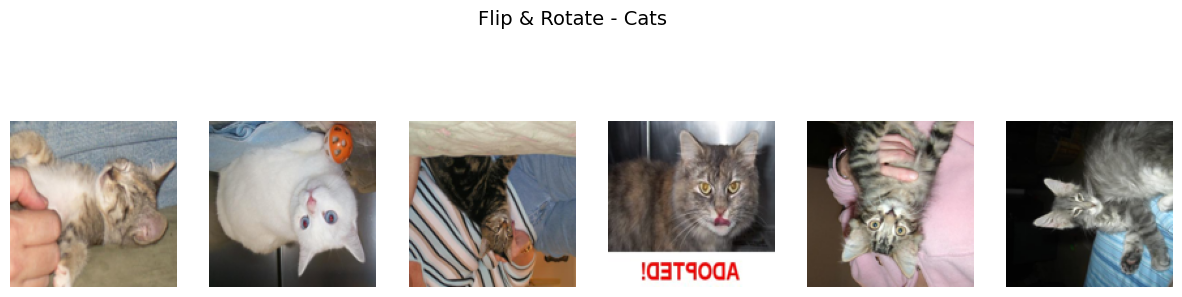

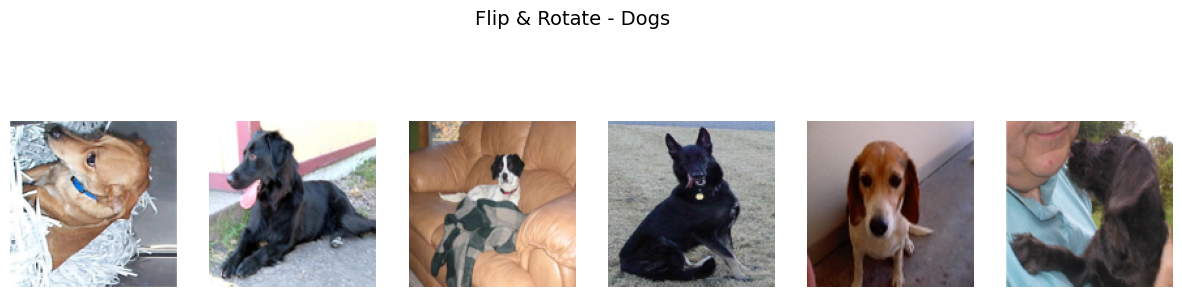

Saved 100 images to /kaggle/working/FlipRotate


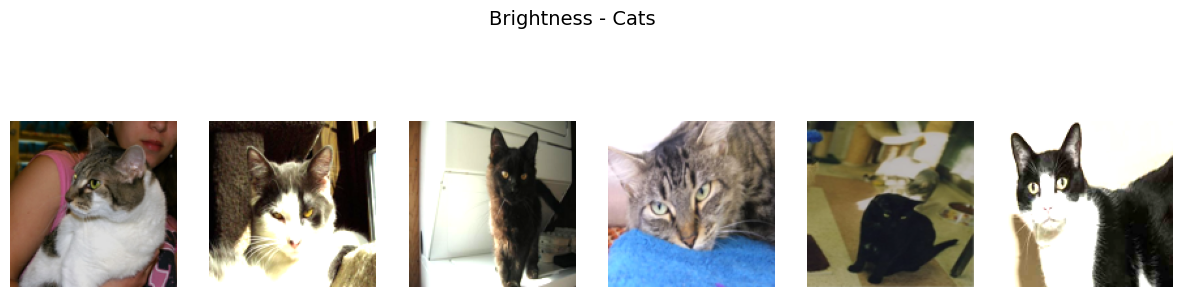

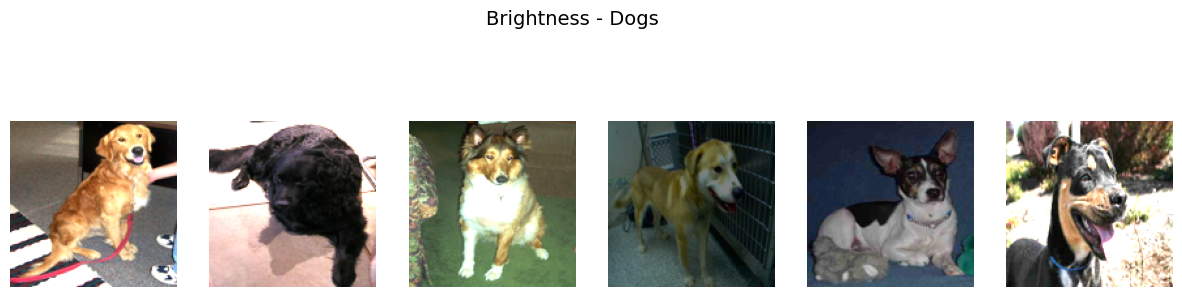

Saved 100 images to /kaggle/working/Brightness


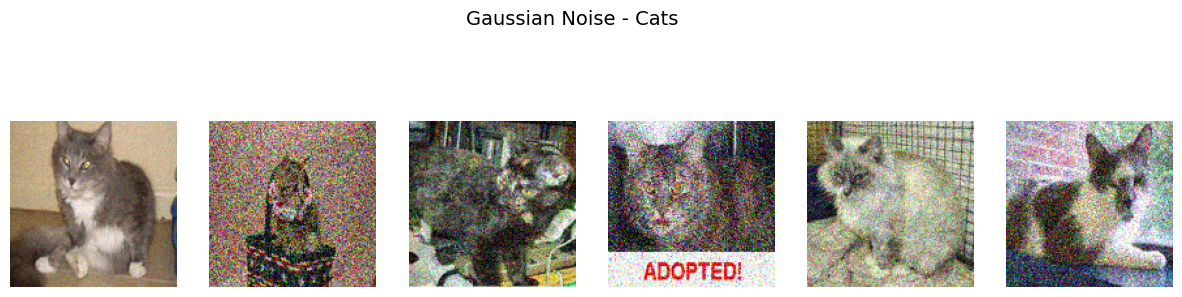

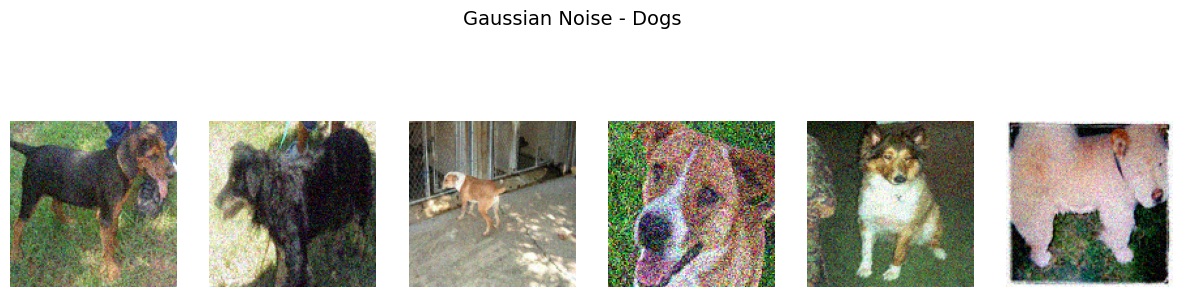

Saved 100 images to /kaggle/working/Gaussian Noise


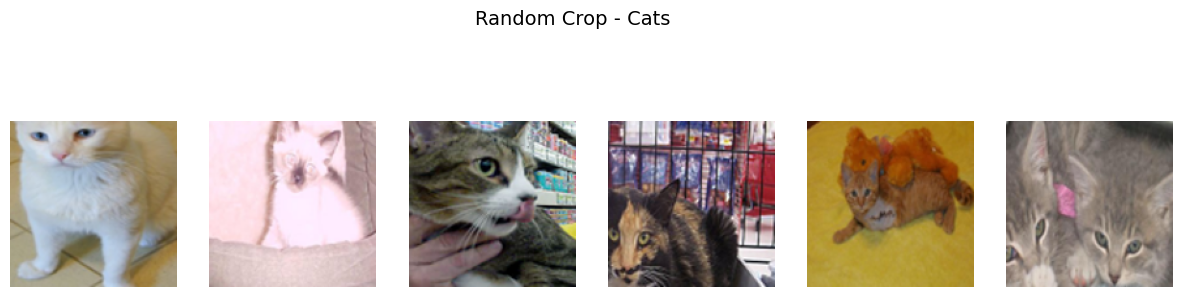

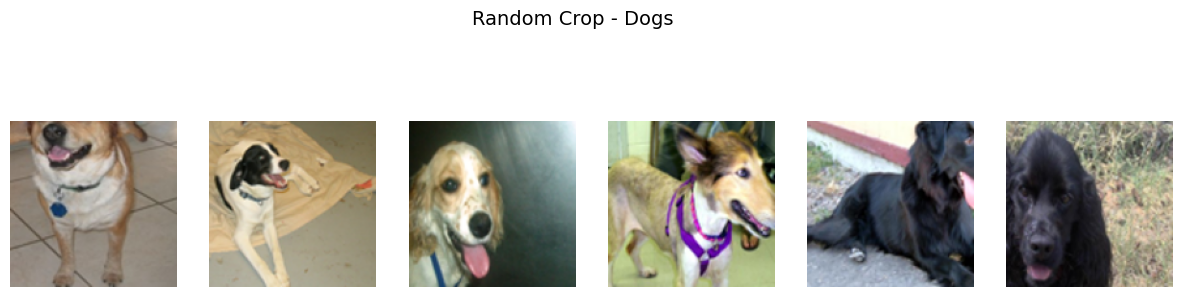

Saved 100 images to /kaggle/working/Random Crop


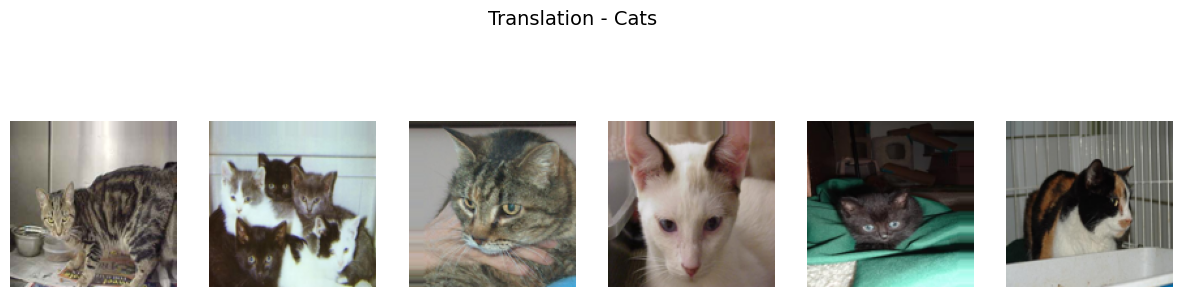

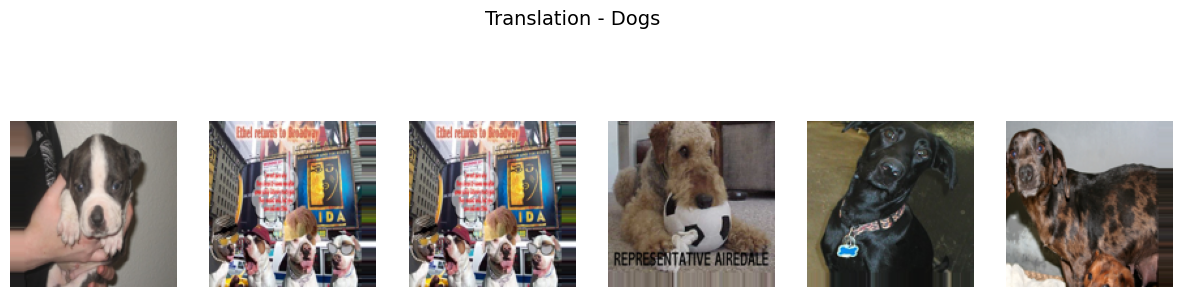

Saved 100 images to /kaggle/working/Translation


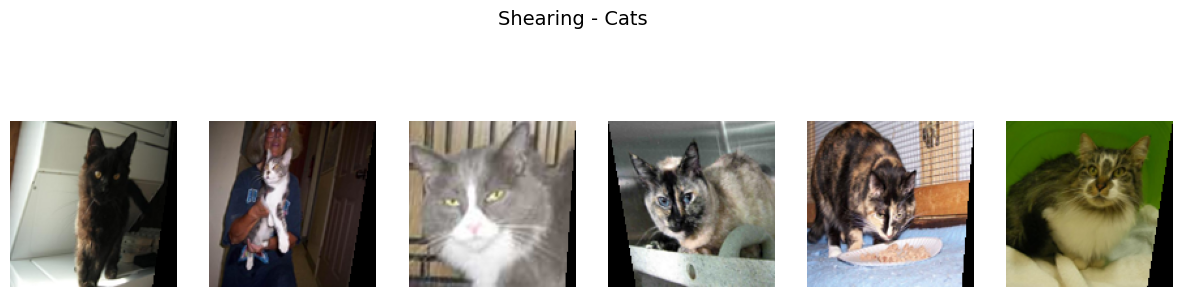

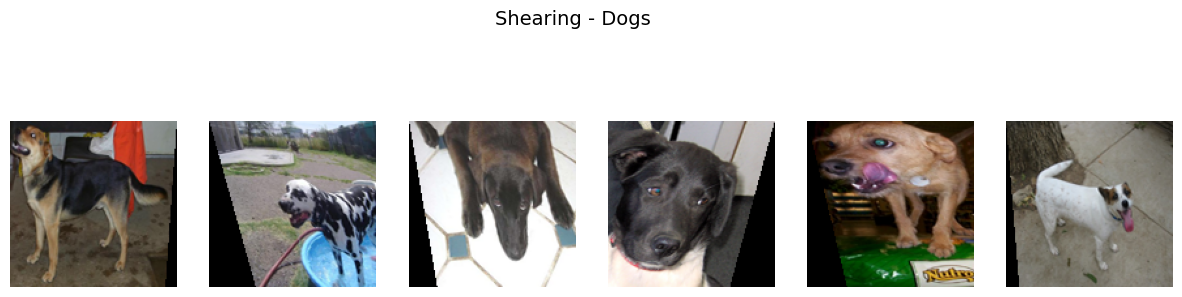

Saved 100 images to /kaggle/working/Shearing


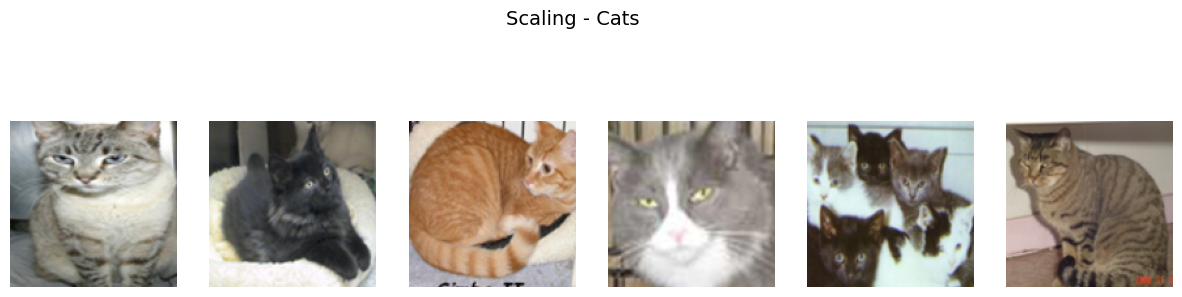

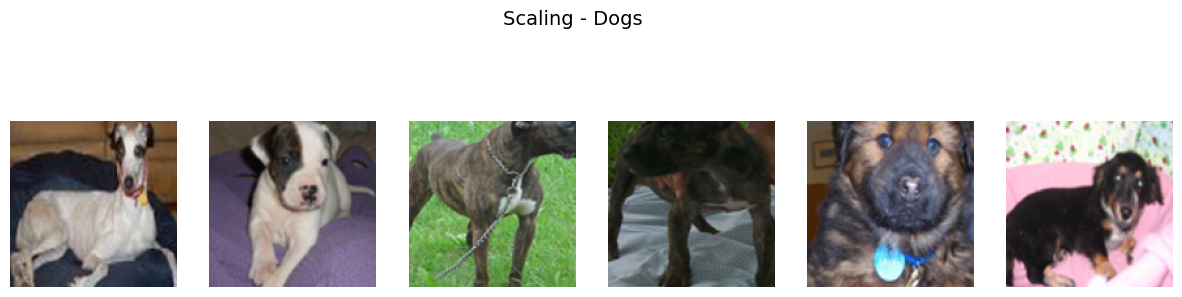

Saved 100 images to /kaggle/working/Scaling


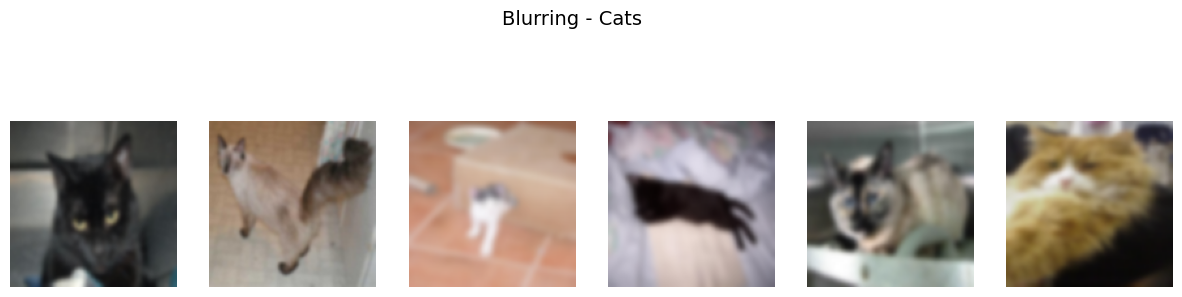

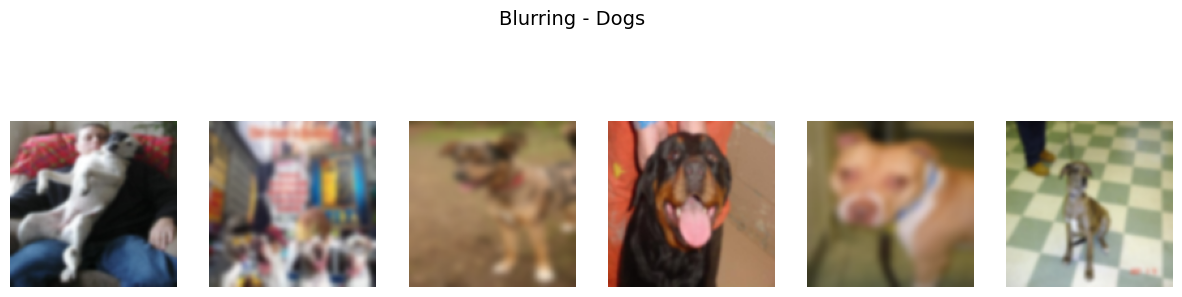

Saved 100 images to /kaggle/working/Blurring


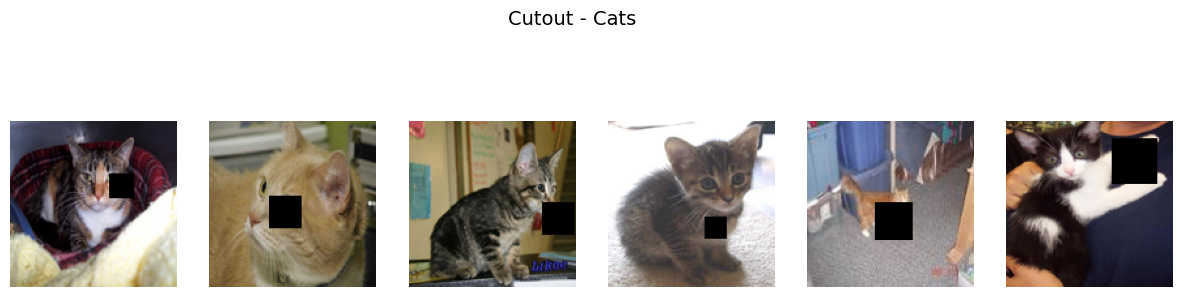

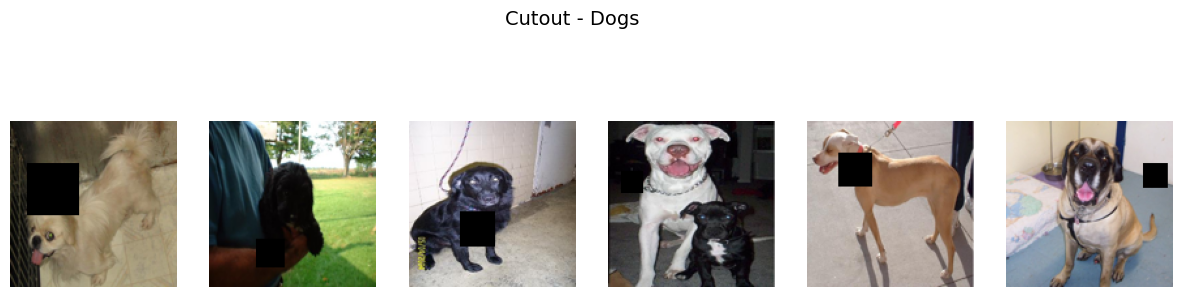

Saved 100 images to /kaggle/working/Cutout
Số ảnh augmented mỗi loại:
100 100 100 100 100 100 100 100 100


In [ ]:
def show_images(imgs, title="", n=6):
    fig, axes = plt.subplots(1, n, figsize=(15, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i])
        ax.axis("off")
    plt.suptitle(title, fontsize=14)
    plt.show()

# tách chó mèo
cats = [X[i] for i in range(len(X)) if y[i] == 0]
dogs = [X[i] for i in range(len(X)) if y[i] == 1]

# Hàm chung: tạo augment cho cả mèo & chó
def make_aug_dataset(aug_func, name, n_per_class=50):
    cats_aug, dogs_aug = [], []

    # augment mèo
    for _ in range(n_per_class):
        img = random.choice(cats)
        cats_aug.append(aug_func(img))

    # augment chó
    for _ in range(n_per_class):
        img = random.choice(dogs)
        dogs_aug.append(aug_func(img))

    # hiển thị riêng mèo và chó (12 tấm ảnh cho mỗi kĩ thuật)
    show_images(cats_aug, f"{name} - Cats", n=6)
    show_images(dogs_aug, f"{name} - Dogs", n=6)

    # gộp mèo + chó lại để return
    imgs = np.array(cats_aug + dogs_aug)
    labels = np.array([0]*len(cats_aug) + [1]*len(dogs_aug))
    return imgs, labels

# Hàm lưu ảnh augmented ra thư mục
def save_augmented(X, y, aug_name, base_dir="/kaggle/working"):
    save_dir = os.path.join(base_dir, aug_name)
    os.makedirs(save_dir, exist_ok=True)

    for i, (img, label) in enumerate(zip(X, y)):
        cls = "cat" if label == 0 else "dog"
        cls_dir = os.path.join(save_dir, cls)
        os.makedirs(cls_dir, exist_ok=True)

        img_pil = Image.fromarray(img)
        img_pil.save(os.path.join(cls_dir, f"{cls}_{i}.jpg"))

    print(f"Saved {len(X)} images to {save_dir}")


# Augmentation
# 1. Flip & Rotate
def aug_flip(img):
    ops = [
        lambda x: x,
        np.fliplr,
        np.flipud,
        lambda x: np.rot90(x, 1),
        lambda x: np.rot90(x, 2),
        lambda x: np.rot90(x, 3)
    ]
    return random.choice(ops)(img)
X_flip, y_flip = make_aug_dataset(aug_flip, "Flip & Rotate")
save_augmented(X_flip, y_flip, "FlipRotate")

# 2. Brightness
def aug_brightness(img):
    img_pil = Image.fromarray(img)
    factor = random.uniform(0.5, 1.8)
    return np.array(ImageEnhance.Brightness(img_pil).enhance(factor))
X_bright, y_bright = make_aug_dataset(aug_brightness, "Brightness")
save_augmented(X_bright, y_bright, "Brightness")

# 3. Gaussian Noise
def add_noise(img, noise_level=25):
    noise = np.random.normal(0, noise_level, img.shape).astype(np.int16)
    noisy = img.astype(np.int16) + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy
X_noise, y_noise = make_aug_dataset(lambda img: add_noise(img, random.choice([10,20,30,40,50])), "Gaussian Noise")
save_augmented(X_noise, y_noise, "Gaussian Noise")

# 4. Random Crop / Zoom
def random_crop(img, crop_size=96):
    h, w, _ = img.shape
    top = np.random.randint(0, h - crop_size)
    left = np.random.randint(0, w - crop_size)
    cropped = img[top:top+crop_size, left:left+crop_size]
    return np.array(Image.fromarray(cropped).resize((128,128)))
X_crop, y_crop = make_aug_dataset(random_crop, "Random Crop")
save_augmented(X_crop, y_crop, "Random Crop")

# 5. Translation
def aug_translate(img, pixels=10):
    shifts = [(pixels,0,0), (-pixels,0,0), (0,pixels,0), (0,-pixels,0)]
    return shift(img, random.choice(shifts), mode='nearest')
X_trans, y_trans = make_aug_dataset(lambda img: aug_translate(img, 10), "Translation")
save_augmented(X_trans, y_trans, "Translation")

# 6. Shearing
def aug_shear(img, shear_factor=None):
    if shear_factor is None:
        shear_factor = random.uniform(-0.3, 0.3)
    img_pil = Image.fromarray(img)
    w, h = img_pil.size
    m = (1, shear_factor, 0, 0, 1, 0)
    return np.array(img_pil.transform((w,h), Image.AFFINE, m, resample=Image.BICUBIC))
X_shear, y_shear = make_aug_dataset(aug_shear, "Shearing")
save_augmented(X_shear, y_shear, "Shearing")

# 7. Scaling / Zoom
def aug_zoom(img, zoom_factor=None):
    if zoom_factor is None:
        zoom_factor = random.uniform(1.1, 1.5)
    img_pil = Image.fromarray(img)
    w, h = img_pil.size
    new_w, new_h = int(w*zoom_factor), int(h*zoom_factor)
    img_zoom = img_pil.resize((new_w, new_h), Image.BICUBIC)
    left = (new_w - w)//2
    top = (new_h - h)//2
    img_zoom = img_zoom.crop((left, top, left+w, top+h))
    return np.array(img_zoom)
X_zoom, y_zoom = make_aug_dataset(aug_zoom, "Scaling")
save_augmented(X_zoom, y_zoom, "Scaling")

# 8. Blurring
def aug_blur(img):
    img_pil = Image.fromarray(img)
    return np.array(img_pil.filter(ImageFilter.GaussianBlur(radius=random.uniform(1, 3))))
X_blur, y_blur = make_aug_dataset(aug_blur, "Blurring")
save_augmented(X_blur, y_blur, "Blurring")

# 9. Cutout
def aug_cutout(img, size=32):
    img_copy = img.copy()
    h, w, _ = img_copy.shape
    y0 = np.random.randint(h - size)
    x0 = np.random.randint(w - size)
    img_copy[y0:y0+size, x0:x0+size] = 0
    return img_copy
X_cutout, y_cutout = make_aug_dataset(lambda img: aug_cutout(img, random.randint(16,40)), "Cutout")
save_augmented(X_cutout, y_cutout, "Cutout")

print("Số ảnh augmented mỗi loại:")
print(len(X_flip), len(X_bright), len(X_noise), len(X_crop),
      len(X_trans), len(X_shear), len(X_zoom), len(X_blur), len(X_cutout))

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.metrics import classification_report
import copy
from torch.utils.data import DataLoader, random_split, ConcatDataset

path = '/kaggle/working/'
class MiniAlexNet(nn.Module):
    def __init__(self, num_classes):
        super(MiniAlexNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((6, 6))
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

aug_folders = ['Blurring', 'Brightness', 'Cutout', 'FlipRotate', 'Gaussian Noise', 'Random Crop', 'Scaling', 'Shearing', 'Translation']
aug_datasets = [datasets.ImageFolder(root=f"/kaggle/working/{folder}", transform=test_transform)
                for folder in aug_folders]

base_dir = "/kaggle/working/original"
os.makedirs(os.path.join(base_dir, "Cat"), exist_ok=True)
os.makedirs(os.path.join(base_dir, "Dog"), exist_ok=True)
for i, f in enumerate(cat_pick):
    img = Image.open(f).convert("RGB").resize((128,128))
    img.save(os.path.join(base_dir, "Cat", f"cat_{i}.jpg"))

for i, f in enumerate(dog_pick):
    img = Image.open(f).convert("RGB").resize((128,128))
    img.save(os.path.join(base_dir, "Dog", f"dog_{i}.jpg"))
orig_dataset = datasets.ImageFolder(root=base_dir, transform=test_transform)
print("Số ảnh gốc:", len(orig_dataset))

total = len(orig_dataset)
train_size = int(0.8*total)
val_size   = int(0.1*total)
test_size  = total - train_size - val_size

train_orig, val_ds, test_ds = random_split(orig_dataset,[train_size,val_size,test_size])
train_orig.dataset.transform = train_transform
val_ds.dataset.transform = test_transform
test_ds.dataset.transform = test_transform
train_ds = ConcatDataset([train_orig] + aug_datasets)

train_loader = DataLoader(train_ds,batch_size=32,shuffle=True)
val_loader   = DataLoader(val_ds,batch_size=32,shuffle=False)
test_loader  = DataLoader(test_ds,batch_size=32,shuffle=False)

print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(orig_dataset.classes)
model = MiniAlexNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

best_val_loss = float("inf")
best_model = None
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    avg_train = train_loss/len(train_loader)
    model.eval()
    val_loss, correct, total = 0,0,0
    with torch.no_grad():
        for imgs,labels in val_loader:
            imgs,labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out,labels)
            val_loss += loss.item()
            _,pred = torch.max(out,1)
            total += labels.size(0)
            correct += (pred==labels).sum().item()
    avg_val = val_loss/len(val_loader)
    val_acc = 100*correct/total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss={avg_train:.4f}, "
          f"Val Loss={avg_val:.4f}, "
          f"Val Acc={val_acc:.2f}%")
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        best_model = copy.deepcopy(model.state_dict())
torch.save(best_model, "minialexnet.pth")

model.load_state_dict(best_model)
y_true,y_pred=[],[]
model.eval()
with torch.no_grad():
    for imgs,labels in test_loader:
        imgs,labels=imgs.to(device),labels.to(device)
        out=model(imgs)
        _,pred=torch.max(out,1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
print(classification_report(y_true,y_pred,target_names=["Cat","Dog"]))

Số ảnh gốc: 400
Train: 1220 Val: 40 Test: 40
Epoch [1/30] Train Loss=0.6930, Val Loss=0.6922, Val Acc=57.50%
Epoch [2/30] Train Loss=0.6890, Val Loss=0.6885, Val Acc=50.00%
Epoch [3/30] Train Loss=0.6830, Val Loss=0.6822, Val Acc=50.00%
Epoch [4/30] Train Loss=0.6716, Val Loss=0.6592, Val Acc=65.00%
Epoch [5/30] Train Loss=0.6510, Val Loss=0.6330, Val Acc=70.00%
Epoch [6/30] Train Loss=0.6467, Val Loss=0.6627, Val Acc=75.00%
Epoch [7/30] Train Loss=0.6146, Val Loss=0.6617, Val Acc=70.00%
Epoch [8/30] Train Loss=0.6184, Val Loss=0.6169, Val Acc=72.50%
Epoch [9/30] Train Loss=0.6044, Val Loss=0.6485, Val Acc=65.00%
Epoch [10/30] Train Loss=0.5883, Val Loss=0.5649, Val Acc=70.00%
Epoch [11/30] Train Loss=0.5743, Val Loss=0.5610, Val Acc=75.00%
Epoch [12/30] Train Loss=0.5547, Val Loss=0.5768, Val Acc=77.50%
Epoch [13/30] Train Loss=0.5361, Val Loss=0.6350, Val Acc=75.00%
Epoch [14/30] Train Loss=0.5298, Val Loss=0.5247, Val Acc=70.00%
Epoch [15/30] Train Loss=0.5153, Val Loss=0.4992, Val 

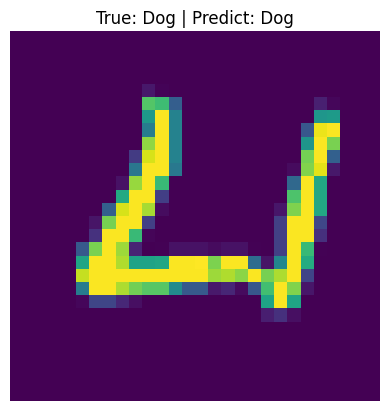

In [12]:
import matplotlib.pyplot as plt


import torch

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.fc1 = nn.Linear(21632, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create model
model = SimpleCNN()

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load test dataset (example with MNIST)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import random
imgs, labels = next(iter(test_loader))
idx = random.randint(0, len(imgs)-1)
img, label = imgs[idx], labels[idx]

model.eval()
with torch.no_grad():
    output = model(img.unsqueeze(0).to(device))
    _, pred = torch.max(output, 1)
    pred = pred.item()

img_show = img * 0.5 + 0.5
img_show = img_show.permute(1,2,0).cpu().numpy()

plt.imshow(img_show)
plt.axis("off")
plt.title(f"True: {'Cat' if label==0 else 'Dog'} | Predict: {'Cat' if pred==0 else 'Dog'}")
plt.show()